In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## EXPLORATORY DATA ANALYSIS

In [2]:
# Data yang akan diproses
customer = pd.read_csv('/content/customer_data.csv')
outlet = pd.read_csv('/content/outlet_data.csv')
product = pd.read_csv('/content/product_data.csv')
staff = pd.read_csv('/content/staff_data.csv')
transaction = pd.read_csv('/content/transaction_data.csv')

# Menggabungkan tabel transaksi, product, outlet dan staff
merge_data = transaction.merge(outlet, on="sales_outlet_id", how="left").merge(product, on="product_id", how="left").merge(staff, on="staff_id", how="left").merge(customer, on='customer_id',how="left")

merge_data['name_staff'] = merge_data['first_name'] + ' ' + merge_data['last_name']

merge_data['start_date'] = pd.to_datetime(merge_data['start_date'])
merge_data['long_working'] = (merge_data['start_date'].dt.year - 2019).astype(int)
merge_data['long_working'] = np.abs(merge_data['long_working'])

merge_data['customer_since'] = pd.to_datetime(merge_data['customer_since'])
merge_data['long_member'] = (merge_data['customer_since'].dt.year - 2019).astype('Int64')
merge_data['long_member'] = np.abs(merge_data['long_member'])
merge_data['long_member'] = merge_data['long_member'].fillna(0)

merge_data['age'] = (2019 - merge_data['birth_year']).astype('Int64')
merge_data['age'] = np.abs(merge_data['age'])
merge_data['age'] = merge_data['age'].fillna(0)

merge_data['total_price'] = merge_data['order_'] * merge_data['unit_price']

data = merge_data[['transaction_id', 'transaction_date', 'transaction_time','sales_outlet_id','instore_yn', 'order_', 'unit_price','total_price', 'promo_item_yn',
                   'store_city', 'product_category', 'product', 'unit_of_measure', 'promo_yn', 'new_product_yn', 'name_staff', 'position',
                   'long_working','customer_id', 'long_member', 'gender','age' ]]

data.sample()

,transaction_id,transaction_date,transaction_time,sales_outlet_id,instore_yn,order_,unit_price,total_price,promo_item_yn,store_city,...,unit_of_measure,promo_yn,new_product_yn,name_staff,position,long_working,customer_id,long_member,gender,age
24789,1362,2019-04-15,15:16:01,5,N,1,42000.0,42000.0,N,Jakarta Selatan,...,24 oz,N,Y,Diajeng Saraswati,Coffee Wrangler,3,0,0,NaN,0


## Visualize Daily Transactions per Outlet

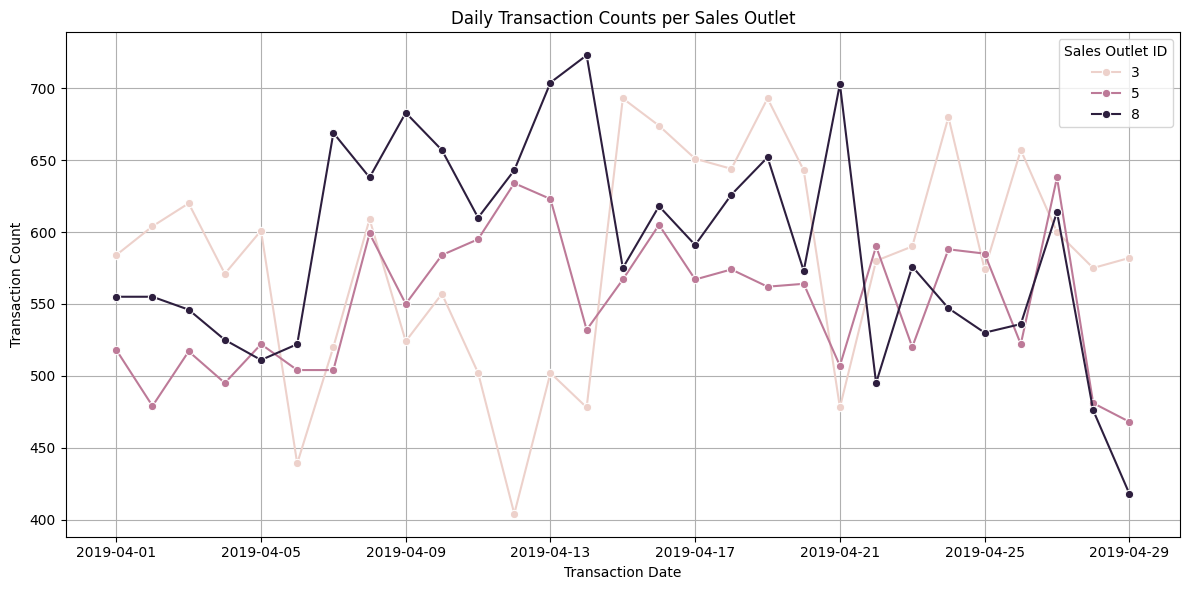

In [3]:
grouped_data = data.groupby(['sales_outlet_id', 'transaction_date'])['transaction_id'].count().reset_index()
grouped_data.rename(columns={'transaction_id': 'transaction_count'}, inplace=True)
grouped_data['transaction_date'] = pd.to_datetime(grouped_data['transaction_date'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data, x='transaction_date', y='transaction_count', hue='sales_outlet_id', marker='o')
plt.title('Daily Transaction Counts per Sales Outlet')
plt.xlabel('Transaction Date')
plt.ylabel('Transaction Count')
plt.legend(title='Sales Outlet ID')
plt.grid(True)
plt.tight_layout()
plt.show()

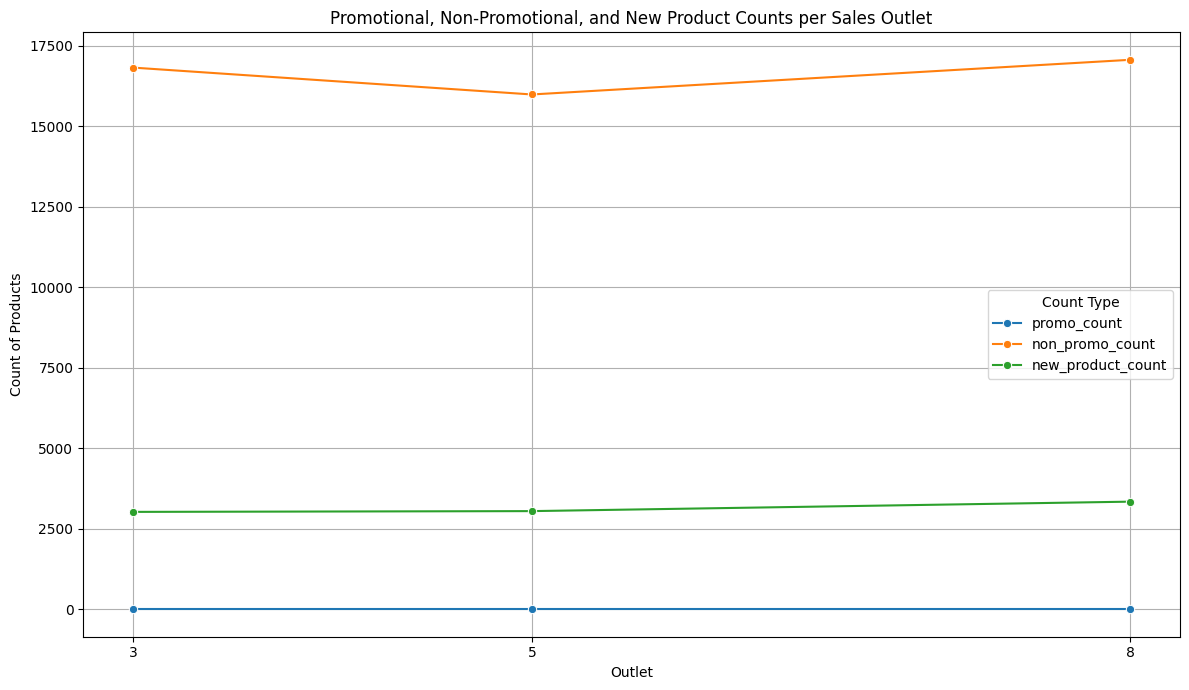

In [4]:
promo_counts = data.groupby(['sales_outlet_id', 'promo_yn']).size().unstack(fill_value=0).reset_index()
promo_counts.rename(columns={'N': 'non_promo_count', 'Y': 'promo_count'}, inplace=True)

new_product_counts = data.groupby(['sales_outlet_id', 'new_product_yn']).size().unstack(fill_value=0).reset_index()
new_product_counts.rename(columns={'N': 'old_product_count', 'Y': 'new_product_count'}, inplace=True)

combined_counts = promo_counts.merge(new_product_counts, on='sales_outlet_id')

promo_counts = data.groupby(['sales_outlet_id', 'promo_yn']).size().unstack(fill_value=0).reset_index()
# Ensure both 'Y' and 'N' columns exist, even if one category was not present in the data
if 'Y' not in promo_counts.columns:
    promo_counts['Y'] = 0
if 'N' not in promo_counts.columns:
    promo_counts['N'] = 0
promo_counts.rename(columns={'N': 'non_promo_count', 'Y': 'promo_count'}, inplace=True)

# Regenerate combined_counts with the corrected promo_counts
combined_counts = promo_counts.merge(new_product_counts, on='sales_outlet_id')

df_plot = combined_counts.melt(id_vars=['sales_outlet_id'], value_vars=['promo_count', 'non_promo_count', 'new_product_count'],
                            var_name='count_type', value_name='count_value')

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_plot, x='sales_outlet_id', y='count_value', hue='count_type', marker='o')
plt.title('Promotional, Non-Promotional, and New Product Counts per Sales Outlet')
plt.xlabel('Outlet')
plt.ylabel('Count of Products')
plt.xticks(df_plot['sales_outlet_id'].unique())
plt.legend(title='Count Type')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Mengkategorikan Waktu
def categorize_time(transaction_time):
  if transaction_time >= pd.to_datetime('08:00:00').time() and transaction_time <= pd.to_datetime('10:00:00').time():
    return 'coffee pagi'
  elif transaction_time >= pd.to_datetime('12:00:00').time() and transaction_time <= pd.to_datetime('14:00:00').time():
    return 'lunch / titip bareng'
  elif transaction_time >= pd.to_datetime('16:00:00').time() and transaction_time <= pd.to_datetime('17:00:00').time():
    return 'afternoon break'
  else:
    return 'Others'

# Melakukan Processing Data
data['transaction_time'] = pd.to_datetime(data['transaction_time'], format='%H:%M:%S').dt.time
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['time_category'] = data['transaction_time'].apply(categorize_time)
data['day_type'] = data['transaction_date'].dt.weekday.apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)

# Membandingkan volume per unit(produk) setiap outlet
vol_unit = data.groupby(['sales_outlet_id','product','product_category','new_product_yn'])[['order_','total_price']].sum().reset_index()

# Menghitung AVG_ITEM_PER_TRANSACTION
avg_item_transaction = data.groupby(['transaction_id','sales_outlet_id','product','new_product_yn'])['order_'].mean().reset_index()
avg_item_transaction.rename(columns={'order_': 'avg_item'}, inplace=True)

# Melihat Performa dari masing masing staff per Outlet
perform_staff = data.groupby(['sales_outlet_id','name_staff','long_working','product','new_product_yn'])[['order_','total_price']].sum().reset_index()
performing_staff = perform_staff.groupby(['sales_outlet_id','name_staff','long_working'])[['order_','total_price']].sum().reset_index()

# Menghitung Revene per Outlet
total_sales_outlet = performing_staff.groupby('sales_outlet_id')[['order_','total_price']].sum()
total_sales_outlet['avg_sales_outlet'] = total_sales_outlet['total_price'] / 29

### Bussiness Question 1


```
"Outlet mana yang siap menerima ekspansi produk baru ?"
```

**Kesiapan outlet merupakan kombinasi dari:**

1️⃣ *Traffic Power → kemampuan menciptakan exposure*

2️⃣ *Basket Strength → kemampuan menghasilkan value per transaksi*

---


### Definisi 4 kuadran
    🟢 Q1 – High Traffic + High Basket (Expansion Ready)
    > Karakter:
      1. Exposure tinggi
      2. Spending kuat
      3. Risiko rendah
    > ➡️ Ini target utama ekspansi.

---
    🟡 Q2 – High Traffic + Low Basket (Awareness Engine)
    > Karakter:
      1. Banyak customer
      2. Tapi pembelian kecil
    > ➡️ Cocok untuk produk entry-level atau promo-driven product.
---
    🔵 Q3 – Low Traffic + High Basket (“Premium Niche”)
    > Karakter:
      1. Customer sedikit
      2. Tapi daya beli tinggi
    > ➡️ Cocok untuk produk high margin, bukan produk volume.
----
    🔴 Q4 – Low Traffic + Low Basket (Not Ready)
    > Karakter:
      1. Exposure rendah
      2. Spending lemah
    > ➡️ Ekspansi di sini berisiko tinggi.

In [6]:
# AVG TRANSACTION PER OUTLET (X axis)
avg_daily = data.groupby(['sales_outlet_id'])['transaction_id'].count().reset_index()
avg_daily['avg_daily_trans']= avg_daily['transaction_id']/29
avg_daily['avg_daily_trans'] = avg_daily['avg_daily_trans'].round(2)
avg_daily.rename(columns={'transaction_id':'total_transaction'}, inplace=True)

# AVG BASKET PER OUTLIET (Y axis)
avg_basket = data.groupby(['sales_outlet_id','transaction_id'])['order_'].sum().reset_index()
avg_basket.rename(columns={'order_': 'total_order'}, inplace=True)
avg_basket['median_basket_size'] = avg_basket.groupby('sales_outlet_id')['total_order'].transform('median')
avg_basket.drop(columns=['transaction_id','total_order'], inplace=True)
avg_basket=avg_basket.drop_duplicates()

bq1 = pd.merge(avg_daily, avg_basket, on='sales_outlet_id',)

# Menghitung Revenue Consistency
# 1. Group by outlet + date and calculate total revenue per day
daily_revenue = data.groupby(['sales_outlet_id', 'transaction_date'])['total_price'].sum().reset_index()
daily_revenue.rename(columns={'total_price': 'daily_revenue'}, inplace=True)

# 2. For each outlet: calculate mean(daily_revenue) and std(daily_revenue)
revenue_stats = daily_revenue.groupby('sales_outlet_id')['daily_revenue'].agg(['mean', 'std']).reset_index()
revenue_stats.rename(columns={'mean': 'mean_daily_revenue', 'std': 'std_daily_revenue'}, inplace=True)

# 3. Calculate CV = std / mean
revenue_stats['cv'] = revenue_stats['std_daily_revenue'] / revenue_stats['mean_daily_revenue']

# Round the 'cv' column to two decimal places
revenue_stats['cv'] = revenue_stats['cv'].round(2)

# Merge bq1 with revenue_stats
bq1 = pd.merge(bq1, revenue_stats[['sales_outlet_id', 'cv']], on='sales_outlet_id', how='left')

# ===== Threshold =====
traffic_cutoff = bq1['avg_daily_trans'].median()
basket_cutoff = bq1['median_basket_size'].median()

# Mengklasifikasi Kesiapan (Readiness)
def classify_readiness(row):
    if row['avg_daily_trans'] >= traffic_cutoff and row['median_basket_size'] >= basket_cutoff:
        return 'Expansion Ready'
    elif row['avg_daily_trans'] >= traffic_cutoff and row['median_basket_size'] < basket_cutoff:
        return 'Awareness Engine'
    elif row['avg_daily_trans'] < traffic_cutoff and row['median_basket_size'] >= basket_cutoff:
        return 'Premium Niche'
    else:
        return 'Not Ready'

bq1['readiness_category'] = bq1.apply(classify_readiness, axis=1)

# Mengklasifikasi Resiko
def classify_risk(cv):
    if cv < 0.30:
        return 'Low Risk (Stable)'
    elif cv < 0.50:
        return 'Medium Risk'
    else:
        return 'High Risk (Volatile)'

bq1['revenue_risk'] = bq1['cv'].apply(classify_risk)

traffic_cutoff = bq1['avg_daily_trans'].median()
basket_cutoff = bq1['median_basket_size'].median()

def classify(row):
    if row['avg_daily_trans'] >= traffic_cutoff and row['median_basket_size'] >= basket_cutoff:
        return 'Expansion Ready'
    elif row['avg_daily_trans'] >= traffic_cutoff and row['median_basket_size'] < basket_cutoff:
        return 'Awareness Engine'
    elif row['avg_daily_trans'] < traffic_cutoff and row['median_basket_size'] >= basket_cutoff:
        return 'Premium Niche'
    else:
        return 'Not Ready'

bq1['readiness_category'] = bq1.apply(classify, axis=1)
bq1

,sales_outlet_id,total_transaction,avg_daily_trans,median_basket_size,cv,readiness_category,revenue_risk
0,3,16829,580.31,3.0,0.64,Awareness Engine,High Risk (Volatile)
1,5,15994,551.52,4.0,0.39,Premium Niche,Medium Risk
2,8,17071,588.66,4.0,0.44,Expansion Ready,Medium Risk


## 🎯 Interpretasi

```
OUTLET 3 :
  - High traffic
  - Low basket
  - High risk

Artinya:
Awareness Engine + Volatile
Bukan outlet paling aman.

```
```
Outlet 5
  - Low traffic
  - High basket
  - Medium risk

Artinya:
Premium Niche + Relatif stabil.
```

```
Outlet 8
  - High traffic
  - High basket
  - Medium risk

Artinya:
Expansion Ready + Medium stability.
Ini kandidat terkuat sejauh ini.
```
---
## Hypotesis Awal
---
### Outlet 8 untuk ekspansi produk baru.

- 1️⃣ Outlet 8 memiliki kombinasi high traffic dan high median basket size, yang menunjukkan exposure kuat sekaligus daya beli customer yang sehat.

- 2️⃣ Dibanding outlet lain, Outlet 8 berada di kuadran “Expansion Ready”, sehingga potensi penetrasi produk baru paling optimal.

- 3️⃣ Meskipun revenue volatility berada di level medium, risikonya masih dalam batas wajar dan lebih stabil dibanding outlet 3 yang sangat fluktuatif.

## 🎯 BQ2 – Product Acceptance

Pertanyaan inti:

***Apakah produk baru benar-benar diterima dengan baik?***

📌 Apa yang Harus di Ukur?

Kita butuh **3 sinyal utama:**

		1️⃣ Volume Acceptance

	Berapa % kontribusi produk baru terhadap total unit terjual?
	𝑁𝑒𝑤_𝑃𝑟𝑜𝑑𝑢𝑐𝑡_𝑈𝑛𝑖𝑡_𝑅𝑎𝑡𝑖𝑜 = Total_Unit_New : Total_Unit_All
		- Kalau cuma 2–3%, berarti lemah.
		- Kalau 10–20%+, mulai menarik.

		2️⃣ Revenue Acceptance

	Berapa % kontribusi revenue dari produk baru?
	New_Revenue_Ratio = Revenue_Total : Revenue_New
	​Kadang unit kecil tapi revenue besar (harga premium).

	3️⃣ Basket Integration

	Apakah produk baru ikut dalam transaksi besar?

	Contoh analisis:
	- Median basket untuk transaksi yang mengandung produk baru
	- Median basket untuk transaksi tanpa produk baru

	Kalau basket naik saat ada produk baru → itu good sign
	Kalau basket turun → kemungkinan cuma substitusi produk lama



In [7]:
# Total unit & revenue per outlet
total_stats = data.groupby('sales_outlet_id').agg({'order_':'sum', 'total_price': 'sum'}).reset_index()
total_stats.rename(columns={'order_':'total_unit_all', 'total_price': 'total_revenue_all'},inplace=True)

# Total unit & revenue produk baru
new_stats = data[data['new_product_yn']=='Y'].groupby('sales_outlet_id').agg({'order_':'sum', 'total_price': 'sum'}).reset_index()
new_stats.rename(columns={'order_':'total_unit_new', 'total_price': 'total_revenue_new'},inplace=True)
new_stats
# Merge total & new stats
acceptance = pd.merge(total_stats, new_stats, on='sales_outlet_id', how='left')
acceptance.fillna(0, inplace=True)

# Ratio
acceptance['unit_ratio_new']= acceptance['total_unit_new']/acceptance['total_unit_all']
acceptance['revenue_ratio_new']= acceptance['total_revenue_new']/acceptance['total_revenue_all']

# Hitung basket per transaksi
basket_txn = data.groupby(['sales_outlet_id', 'transaction_id']).agg({'order_':'sum','new_product_yn':'max'}).reset_index()
basket_txn.rename(columns={'order_':'basket_size'}, inplace=True)

# Banding median BASKET
basket_compare = basket_txn.groupby(['sales_outlet_id','new_product_yn'])['basket_size'].median().reset_index()
basket_compare.rename(columns={'basket_size':'median_size'}, inplace=True)
basket_compare_y = basket_compare[basket_compare['new_product_yn']=='Y']
basket_compare_n = basket_compare[basket_compare['new_product_yn']=='N']

# Merge
product_acceptance = pd.merge(acceptance, basket_compare_y, on='sales_outlet_id', how='left')
product_acceptance

,sales_outlet_id,total_unit_all,total_revenue_all,total_unit_new,total_revenue_new,unit_ratio_new,revenue_ratio_new,new_product_yn,median_size
0,3,19251,1.154772e+09,3160,126007800.0,0.164147,0.109119,Y,4.0
1,5,19157,1.215553e+09,3220,130300800.0,0.168085,0.107195,Y,5.0
2,8,20139,1.257182e+09,3518,142060200.0,0.174686,0.112999,Y,5.0


```
🎯 Interpretasi

Kalau misalnya:
Outlet 8:
  - unit_ratio_new = 0.18
  - revenue_ratio_new = 0.22

Artinya:
  18% unit terjual adalah produk baru
  22% revenue berasal dari produk baru

Itu strong acceptance.
> unit_ratio tinggi + revenue_ratio tinggi
  = produk baru punya exposure & kontribusi penjualan yang baik
```

```
🎯 Interpretasi:

Kalau median basket saat new_product_yn = 1 lebih tinggi
→ produk baru meningkatkan basket value.

Kalau lebih rendah
→ kemungkinan hanya substitusi produk lama.
```

```
🔥 Jadi acceptance tinggi belum tentu growth tinggi

Ada 2 jenis acceptance:

1️⃣ Incremental Acceptance
Produk baru bikin orang beli lebih banyak

2️⃣ Substitution Acceptance
Produk baru cuma menggantikan produk lama

Kalau basket_with_new lebih kecil,
kemungkinan besar itu substitution.
```



```
🔥 Bedanya Substitution vs Market Expansion
1️⃣ Substitution Effect
    -Total transaksi tetap
    -Basket turun
    -Revenue total stagnan
    -Produk lama tergantikan
Artinya cuma pindah-pindah uang.

2️⃣ Customer Base Expansion
    -Total transaksi meningkat
    -Customer count meningkat
    -Revenue total naik meskipun basket turun
    -Produk baru menarik segmen harga sensitif
Artinya market bertambah.
```



In [8]:
# Unique customer total per outlet
cust_total = data.groupby('sales_outlet_id')['customer_id'] \
                 .nunique() \
                 .reset_index()

cust_total.rename(columns={'customer_id': 'unique_customer_all'}, inplace=True)

# Unique Customer yang Pernah Beli Produk Baru
cust_new = data[data['new_product_yn'] == 'Y'] \
            .groupby('sales_outlet_id')['customer_id'] \
            .nunique() \
            .reset_index()

cust_new.rename(columns={'customer_id': 'unique_customer_new'}, inplace=True)

# Ambil customer yang pernah beli produk baru
cust_new_detail = data[data['new_product_yn'] == 'Y'] \
                    .groupby(['sales_outlet_id', 'customer_id'])['long_member'] \
                    .median() \
                    .reset_index()

# Median tenure per outlet
median_tenure_new = cust_new_detail.groupby('sales_outlet_id')['long_member'] \
                                     .median() \
                                     .reset_index()

median_tenure_new.rename(columns={'long_member': 'median_long_member_new'}, inplace=True)

# Merge
product_acceptance = product_acceptance.merge(cust_total, on='sales_outlet_id', how='left')
product_acceptance = product_acceptance.merge(cust_new, on='sales_outlet_id', how='left')
product_acceptance = product_acceptance.merge(median_tenure_new, on='sales_outlet_id', how='left')

product_acceptance.fillna(0, inplace=True)

# Customer Penetration Ratio
product_acceptance['customer_penetration_new'] = \
    product_acceptance['unique_customer_new'] / product_acceptance['unique_customer_all']

product_acceptance

,sales_outlet_id,total_unit_all,total_revenue_all,total_unit_new,total_revenue_new,unit_ratio_new,revenue_ratio_new,new_product_yn,median_size,unique_customer_all,unique_customer_new,median_long_member_new,customer_penetration_new
0,3,19251,1.154772e+09,3160,126007800.0,0.164147,0.109119,Y,4.0,801,653,1.0,0.815231
1,5,19157,1.215553e+09,3220,130300800.0,0.168085,0.107195,Y,5.0,946,770,1.0,0.813953
2,8,20139,1.257182e+09,3518,142060200.0,0.174686,0.112999,Y,5.0,503,479,1.0,0.952286


## FREAMWORK
### Formalisasi Leverage Score (BQ2)

In [9]:
# Network median
median_revenue_ratio = product_acceptance['revenue_ratio_new'].median()
median_penetration = product_acceptance['customer_penetration_new'].median()
median_unit_ratio = product_acceptance['unit_ratio_new'].median()

median_revenue_ratio, median_penetration, median_unit_ratio

# Membuat LEVERAGE SCORING
def leverage_score(row):
    score = 0

    if row['revenue_ratio_new'] > median_revenue_ratio:
        score += 1

    if row['customer_penetration_new'] > median_penetration:
        score += 1

    if row['unit_ratio_new'] > median_unit_ratio:
        score += 1

    return score

product_acceptance['leverage_score'] = product_acceptance.apply(leverage_score, axis=1)

# KATEGORIS
def leverage_category(score):
    if score == 3:
        return "High"
    elif score == 2:
        return "Medium"
    else:
        return "Low"

product_acceptance['leverage_category'] = \
    product_acceptance['leverage_score'].apply(leverage_category)

'''Leverage is defined as multi-dimensional validation of revenue contribution, customer penetration, and volume adoption.'''

'''🔥 INTERPRETASI STRATEGIS
Outlet 8 bukan hanya “lebih tinggi sedikit”.

Dia:
  1. Revenue ratio tertinggi
  2. Penetration tertinggi
  3. Unit ratio tertinggi

Itu berarti:

Produk baru benar-benar:
  - Diterima
  - Dibeli banyak customer
  - Berkontribusi signifikan ke revenue

Itu sudah menyelesaikan BQ2 secara formal.'''

'🔥 INTERPRETASI STRATEGIS\nOutlet 8 bukan hanya “lebih tinggi sedikit”.\n\nDia:\n  1. Revenue ratio tertinggi\n  2. Penetration tertinggi\n  3. Unit ratio tertinggi\n\nItu berarti:\n\nProduk baru benar-benar:\n  - Diterima\n  - Dibeli banyak customer\n  - Berkontribusi signifikan ke revenue\n\nItu sudah menyelesaikan BQ2 secara formal.'

### FORMALISASI RISK SCORE (BQ3)
***Apakah outlet dengan leverage tinggi juga stabil dan siap secara operasional?***

Karena high leverage tanpa stability = berbahaya.

In [10]:
# merge CV dari bq1 ke product_acceptance
product_acceptance = product_acceptance.merge(
    bq1[['sales_outlet_id','cv']],
    on='sales_outlet_id',
    how='left'
)

# Risk Scoring
def risk_score(cv):
    if cv > 0.5:
        return 2
    elif cv >= 0.4:
        return 1
    else:
        return 0

product_acceptance['risk_score'] = product_acceptance['cv'].apply(risk_score)

# Risk Category
def risk_category(score):
    if score == 2:
        return "High"
    elif score == 1:
        return "Medium"
    else:
        return "Low"

product_acceptance['risk_category'] = \
    product_acceptance['risk_score'].apply(risk_category)

'''
Rule Framework:

1️⃣ High Leverage + Low Risk → Full Launch
2️⃣ High Leverage + Medium Risk → Pilot Launch
3️⃣ Medium Leverage + Low Risk → Controlled Test
4️⃣ Low Leverage + High Risk → Hold
5️⃣ Sisanya → Not Priority

'''

# Metrik LAUNCH DECISION
def launch_decision(row):

    if row['leverage_category'] == 'High' and row['risk_category'] == 'Low':
        return 'Full Launch'

    elif row['leverage_category'] == 'High' and row['risk_category'] == 'Medium':
        return 'Pilot Launch'

    elif row['leverage_category'] == 'Medium' and row['risk_category'] == 'Low':
        return 'Controlled Test'

    elif row['leverage_category'] == 'Low' and row['risk_category'] == 'High':
        return 'Hold'

    else:
        return 'Not Priority'

product_acceptance['launch_decision'] = \
    product_acceptance.apply(launch_decision, axis=1)


In [11]:
product_acceptance

,sales_outlet_id,total_unit_all,total_revenue_all,total_unit_new,total_revenue_new,unit_ratio_new,revenue_ratio_new,new_product_yn,median_size,unique_customer_all,unique_customer_new,median_long_member_new,customer_penetration_new,leverage_score,leverage_category,cv,risk_score,risk_category,launch_decision
0,3,19251,1.154772e+09,3160,126007800.0,0.164147,0.109119,Y,4.0,801,653,1.0,0.815231,0,Low,0.64,2,High,Hold
1,5,19157,1.215553e+09,3220,130300800.0,0.168085,0.107195,Y,5.0,946,770,1.0,0.813953,0,Low,0.39,0,Low,Not Priority
2,8,20139,1.257182e+09,3518,142060200.0,0.174686,0.112999,Y,5.0,503,479,1.0,0.952286,3,High,0.44,1,Medium,Pilot Launch
